In [99]:
# !pip install TA-Lib
# !pip install mplfinance


In [100]:
import pandas as pd
import mplfinance as mpf
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import talib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterSampler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# read data

In [137]:
df=pd.read_csv('./data-price-stock.csv')

In [138]:
# df= pd.read_csv('./data.csv')
df.head(1)

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,1,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410


In [139]:
df.shape

(459335, 7)

In [104]:
df['Ticker'].value_counts()

Ticker
2    135354
3    125309
4    101266
1     97406
Name: count, dtype: int64

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459335 entries, 0 to 459334
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  int64  
 1   Date/Time      459335 non-null  object 
 2   Open           459335 non-null  float64
 3   High           459335 non-null  float64
 4   Low            459335 non-null  float64
 5   Close          459335 non-null  float64
 6   Volume         459335 non-null  int64  
 7   Open Interest  459335 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 28.0+ MB


# EDA

> - describe data 

In [106]:
df.describe()

,Ticker,Open,High,Low,Close,Volume,Open Interest
count,459335.000000,459335.000000,459335.000000,459335.000000,459335.000000,4.593350e+05,459335.0
mean,2.501671,74.545826,74.626579,74.481065,74.546183,4.909390e+03,0.0
std,1.055955,23.023346,23.038201,23.011619,23.024380,1.902104e+04,0.0
min,1.000000,30.250000,30.250000,30.220000,30.250000,1.000000e+00,0.0
25%,2.000000,54.190000,54.250000,54.150000,54.190000,3.600000e+02,0.0
50%,2.000000,75.730000,75.920000,75.600000,75.720000,1.500000e+03,0.0
75%,3.000000,90.100000,90.200000,90.000000,90.100000,4.920000e+03,0.0
max,4.000000,126.100000,126.500000,126.100000,126.500000,3.300680e+06,0.0


> - convert column Data/Time to datatime type

In [107]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459335 entries, 0 to 459334
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         459335 non-null  int64         
 1   Date/Time      459335 non-null  datetime64[ns]
 2   Open           459335 non-null  float64       
 3   High           459335 non-null  float64       
 4   Low            459335 non-null  float64       
 5   Close          459335 non-null  float64       
 6   Volume         459335 non-null  int64         
 7   Open Interest  459335 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 28.0 MB


> - check nan

In [108]:
df.isna().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

> - drop duplicate

In [109]:
df=df.drop_duplicates()
df.shape

(459335, 8)

> # Analysis Price Movements Over Time

> ## Close Price

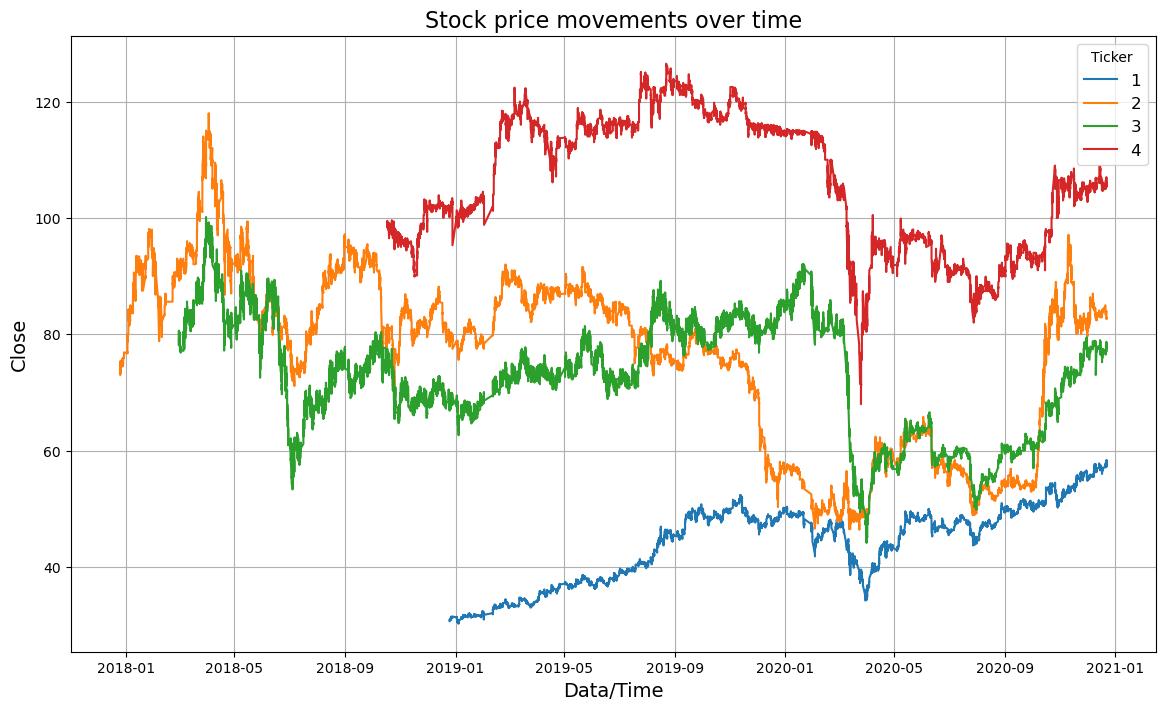

In [110]:
plt.figure(figsize=(14, 8))
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker]  
    plt.plot(subset['Date/Time'], subset['Close'], label=ticker)

plt.title("Stock price movements over time", fontsize=16)
plt.xlabel("Data/Time", fontsize=14)
plt.ylabel("Close", fontsize=14)
plt.legend(title="Ticker", fontsize=12)
plt.grid()
plt.show()

- Overall, stock values fluctuated significantly from 2018 to 2021. Around early 2019 to 2020, there was strong growth, possibly due to the signing of global trade agreements and the positive effects of the U.S-China trade war. From mid-2019 to 2021, there were major changes, with most stocks cooling down gradually due to the impact of COVID-19. Around April, stock values dropped sharply due to social distancing measures. By May, the stock market began to stabilize and recover, thanks to the easing of restrictions and efforts to stimulate economic recovery.

> ## volume of ticker

In [111]:
tickers = df['Ticker'].unique() 
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    print(subset['Volume'].max())


1255930
3300680
580730
1468390


In [112]:
def format_number(x, pos):
    return f'{int(x):,}'

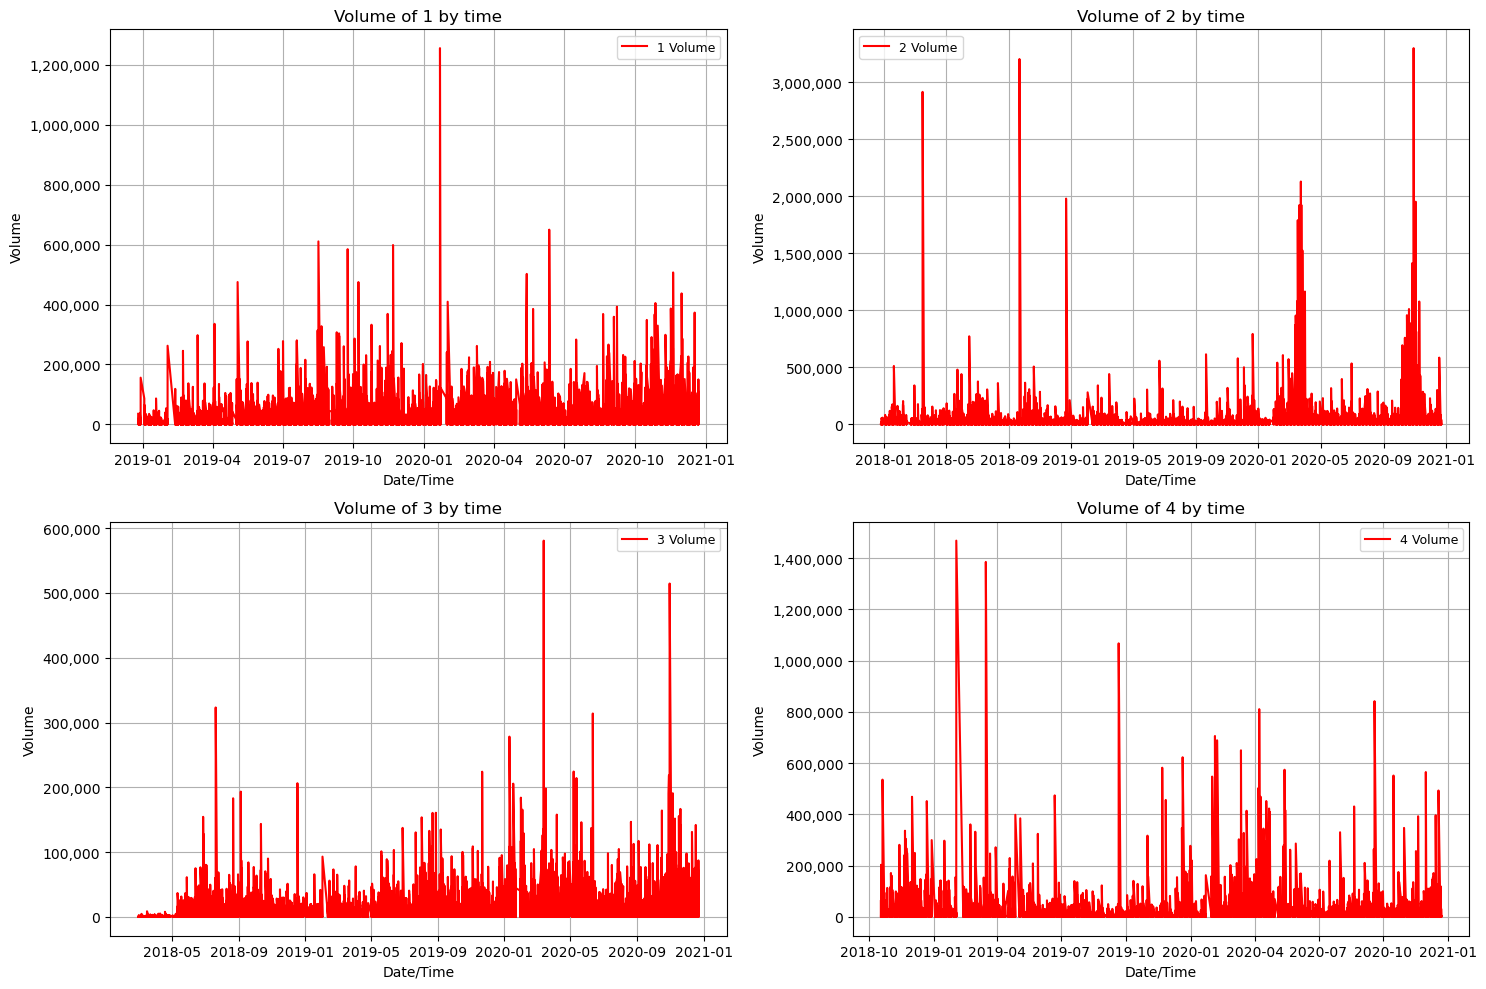

In [113]:
tickers = df['Ticker'].unique()
n_tickers = len(tickers)

n_cols = 2  
n_rows = math.ceil(n_tickers / n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, ticker in enumerate(tickers):
    subset = df[df['Ticker'] == ticker]
    
    ax = axes[i]
    ax.plot(subset['Date/Time'], subset['Volume'], label=f"{ticker} Volume", color='red')
    ax.set_title(f"Volume of {ticker} by time", fontsize=12)
    ax.set_xlabel("Date/Time", fontsize=10)
    ax.set_ylabel("Volume", fontsize=10)
    ax.yaxis.set_major_formatter(FuncFormatter(format_number))
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### **Observations for Each Ticker:**  

1. **1**:  
   - **Trading volume steadily increased** from 2019, peaking significantly in early 2020.  
   - Benefited from **digital transformation** and a surge in technology demand during the COVID-19 period (e.g., consumers staying home due to lockdowns increased usage of technology and devices).  

2. **2**:  
   - **Highly fluctuating trading volume**, with significant peaks at the end of 2018 and the end of 2020.  
   - From early 2020 to April 2020, despite lockdowns, trading volume was higher than in previous years, likely due to increased demand for essential goods during the pandemic, benefiting from shifts in consumer habits.  

3. **3**:  
   - Lower trading volume compared to other stocks, but with a **major peak in mid-2020**.  
   - Despite challenges during social distancing, trading volume peaked during this period, possibly influenced by the pandemic (e.g., consumers selling jewelry to cover expenses or buying gold as a safe haven).  

4. **4**:  
   - Significant fluctuations with **major peaks in early 2019 and mid-2020**.  
   - Sensitive to changes in the real estate and retail sectors.  
   - Peaks in trading volume are often linked to critical news or treasury stock transactions.  

**Summary**:  
- **1** and **3** benefited from increased demand for technology and gold.  
- **2** and **4** experienced greater volatility, driven by macroeconomic and sector-specific factors.  

> ##  Price Volatility Distribution (Delta_Price)

- Price volatility distribution (Delta_Price) provides insights into how much and how frequently the price of an asset fluctuates over a given period. This metric is often used to gauge market behavior and assess risk.

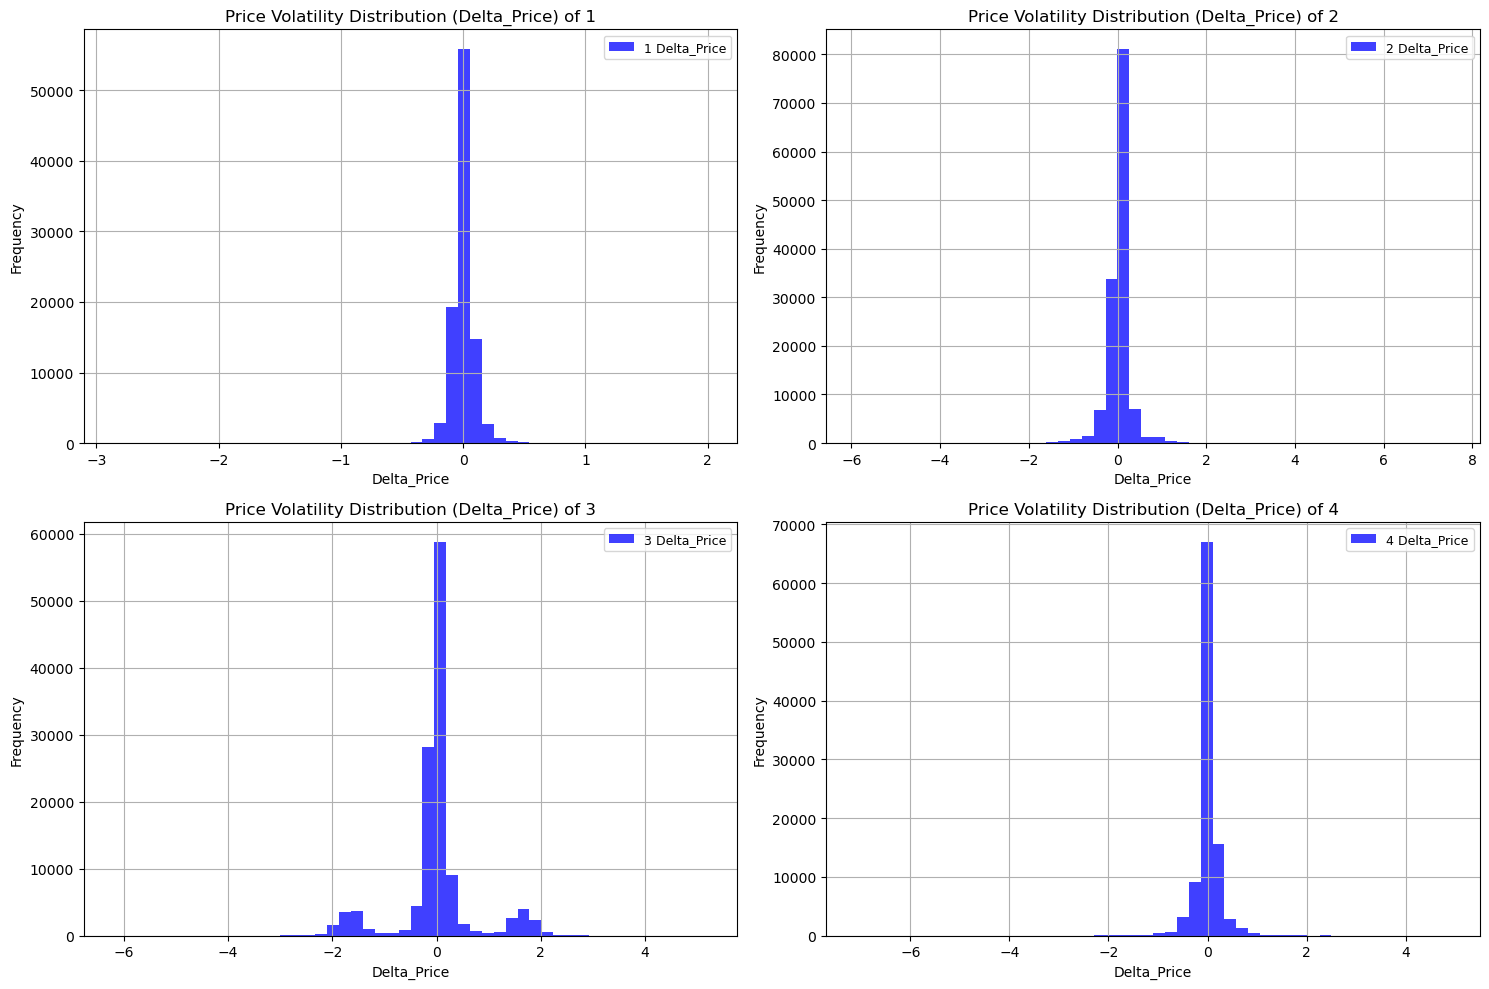

In [114]:
df['Delta_Price'] = df.groupby('Ticker')['Close'].diff(periods=3)
tickers = df['Ticker'].unique()
n_tickers = len(tickers)

n_rows = math.ceil(n_tickers / n_cols) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

for i, ticker in enumerate(tickers):
    subset = df[df['Ticker'] == ticker]
    
    ax = axes[i]
    ax.hist(subset['Delta_Price'].dropna(), bins=50, alpha=0.75, label=f"{ticker} Delta_Price", color='blue')
    ax.set_title(f"Price Volatility Distribution (Delta_Price) of {ticker}", fontsize=12)
    ax.set_xlabel("Delta_Price", fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### **Combined Observations with Evaluations**:

**1. 1**:  
- **Highly stable and predictable**:  
  - The price volatility distribution is narrow and centered around 0, indicating low and stable price fluctuations.  
  - **Ideal for long-term investors** seeking steady growth, especially in the tech sector known for its sustainability.  
- **Summary**: 1 is suitable for those prioritizing low risk and expecting consistent growth over time.  

**2. 2**:  
- **Highly volatile and risky**:  
  - A wide distribution with extreme values demonstrates **sensitivity to market news and external factors**.  
  - **High profit potential for short-term trading**, but also comes with significant risks, requiring a solid strategy and risk tolerance.  
- **Summary**: 2 suits short-term or risk-taking investors aiming to capitalize on price fluctuations for quick profits.

**3. 3**:  
- **Moderately stable with occasional large swings**:  
  - The price volatility is mostly narrow but shows sudden spikes during sensitive periods (e.g., COVID-19, gold price fluctuations).  
  - **Good adaptability during crises**, benefiting from the demand for gold as a safe-haven asset or changes in consumer behavior.  
- **Summary**: 3 strikes a balance between stability and earning potential, suitable for medium- and long-term investors, especially during periods when gold acts as a risk-hedging asset.  

**4. 4**:  
- **Sensitive to macroeconomic factors**:  
  - Price volatility is relatively stable but significantly influenced by news or policies related to real estate and retail sectors.  
  - **Appeals to speculative investors**, as price movements are often linked to major news or industry trends.  
- **Summary**: 4 suits those interested in short-term speculation or closely monitoring trends in the real estate market.  

**Overall Summary**:  
1. **1**: The most stable, ideal for long-term investors seeking low risk.  
2. **2**: The most volatile, suitable for short-term traders optimizing profits from fluctuations.  
3. **3**: Moderately stable with potential during sensitive periods, like gold price volatility or changes in consumer behavior.  
4. **4**: Sensitive to macroeconomic trends and sector news, suitable for short-term speculators or tracking real estate market trends.  
  

# set index

In [115]:
# df.set_index('Date/Time', inplace=True)
# df.head(1)

In [116]:
time_series_data = df.iloc[:, 1:-2]
time_series_data


,Date/Time,Open,High,Low,Close,Volume
0,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500
...,...,...,...,...,...,...
459330,2020-12-22 14:22:00,105.80,105.80,105.70,105.70,1870
459331,2020-12-22 14:23:00,105.70,105.70,105.70,105.70,2510
459332,2020-12-22 14:24:00,105.70,105.70,105.70,105.70,3620
459333,2020-12-22 14:25:00,105.70,105.70,105.70,105.70,100


# Calculating the Range
**Gap** measures the difference between the opening price of the current session and the closing price of the previous session.
1. **Market Sentiment Assessment**:
   - **Positive Gap**: The opening price is higher than the previous session's closing price → Indicates positive investor sentiment, possibly due to favorable news overnight.
   - **Negative Gap**: The opening price is lower than the previous session's closing price → Indicates negative sentiment, potentially driven by risk concerns or unfavorable news.

2. **Short-Term Trend Identification**:
   - **Gap Up**: Suggests potential for upward price movement.
   - **Gap Down**: Suggests potential for downward price movement.

In [117]:
df['Grap']= df['Open']-df['Close'].shift(1)

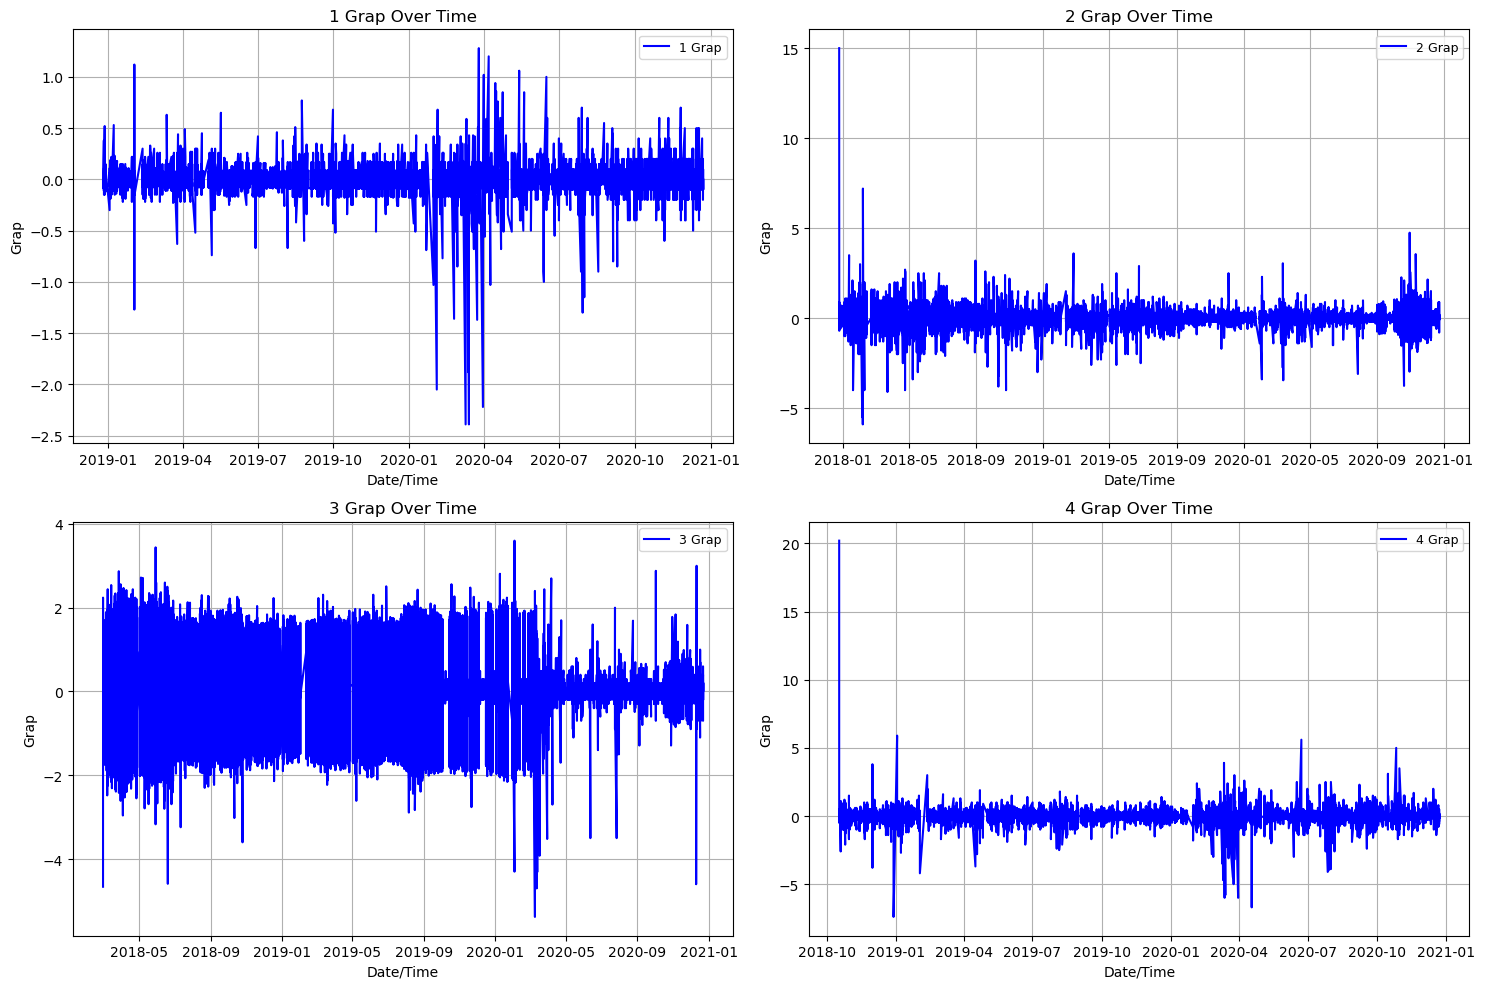

In [118]:
tickers = df['Ticker'].unique()
n_tickers = len(tickers)

n_rows = math.ceil(n_tickers / n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, ticker in enumerate(tickers):
    ticker_data = df[df['Ticker'] == ticker]
    
    ax = axes[i]
    ax.plot(ticker_data['Date/Time'], ticker_data['Grap'], label=f"{ticker} Grap", color='blue')
    ax.set_title(f"{ticker} Grap Over Time", fontsize=12)
    ax.set_xlabel("Date/Time", fontsize=10)
    ax.set_ylabel("Grap", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

**1. 1 Grap Over Time**:  
   - **Small and stable fluctuations**, with values mainly ranging between -1 and +1.  
   - Some **significant negative Grap points** occurred in early 2020, possibly related to the strong market fluctuations at the onset of the COVID-19 pandemic.  

**2. 2 Grap Over Time**:  
   - **The most volatile** among the four stocks, with some Grap values exceeding ±10.  
   - 2 tends to react strongly to major events or unexpected news, particularly during late 2018 and 2020.  

**3. 3 Grap Over Time**:  
   - Relatively **stable**, but there are significant fluctuations on both the negative and positive sides (±4), especially in 2020.  

**4. 4 Grap Over Time**:  
   - Fluctuations mostly within the ±2 range, though there were some significant peaks during critical periods (notably late 2018 and mid-2020).  

**Summary**:  
1. **1**: The most stable, with minimal major fluctuations → suitable for long-term investment.  
2. **2**: The most volatile, creating opportunities for short-term trading.  
3. **3**: Moderately stable, sensitive to gold prices and the consumer market.  
4. **4**: Moderately volatile, reflecting clear macroeconomic trends in real estate.  

# continuation candlestick measurement

Candle-size is a metric that measures price changes during a trading session.

In [119]:
df['cadle-size']=df['Close']-df['Open']

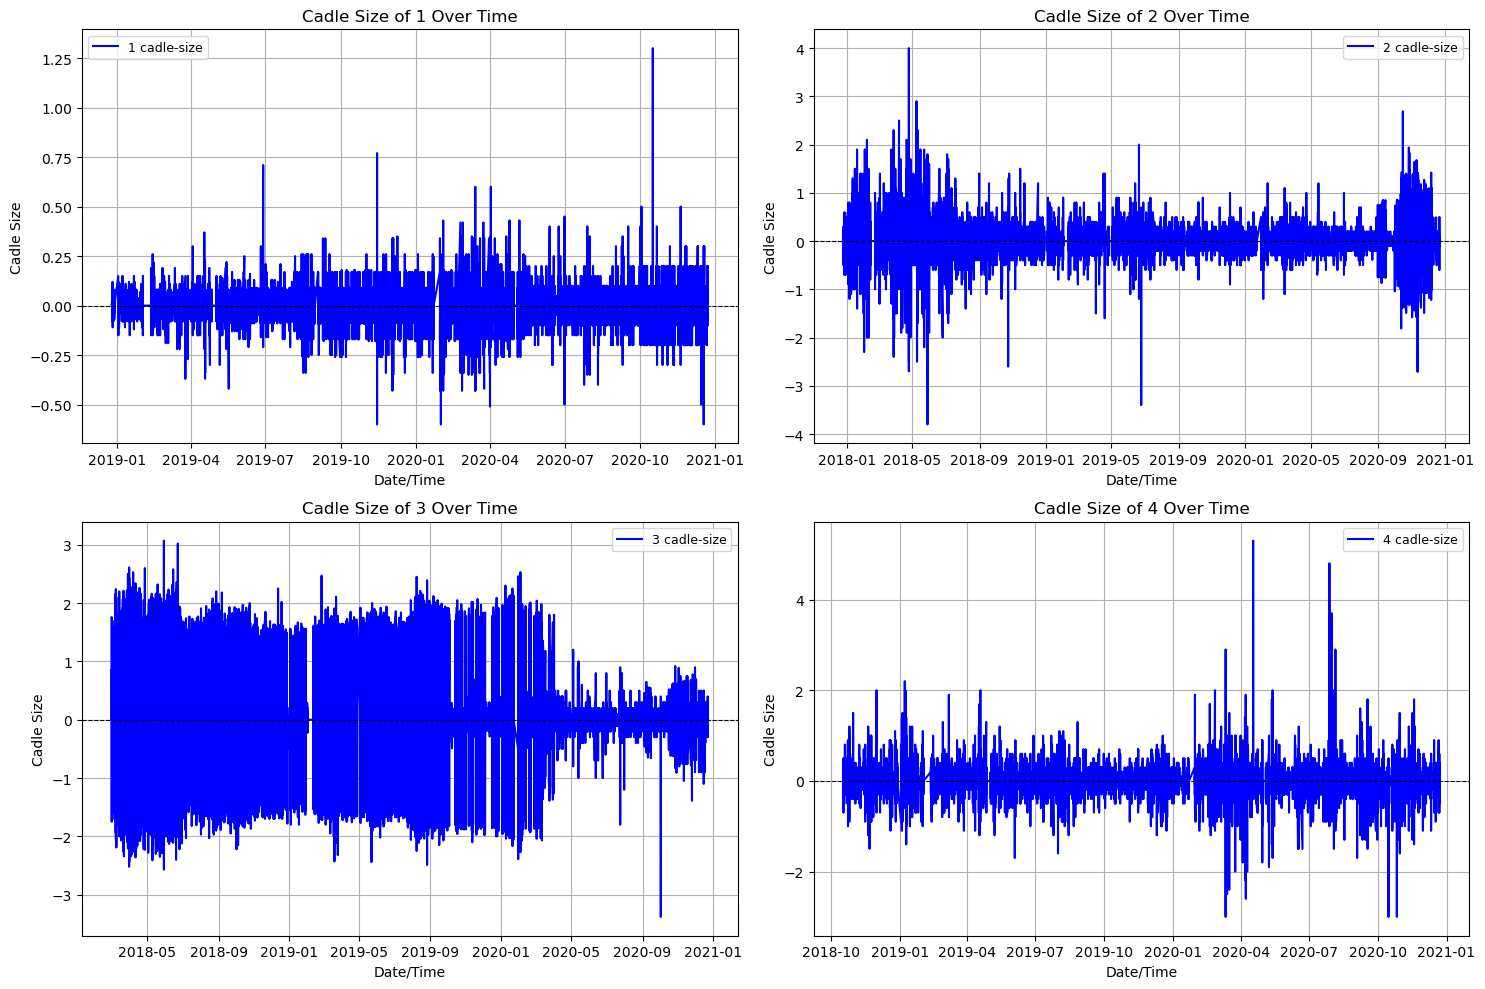

In [120]:
n_rows = math.ceil(n_tickers / n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

for i, ticker in enumerate(tickers):
    ticker_data = df[df['Ticker'] == ticker]
    
    ax = axes[i]
    ax.plot(ticker_data['Date/Time'], ticker_data['cadle-size'], label=f"{ticker} cadle-size", color='blue')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--') 
    ax.set_title(f"Cadle Size of {ticker} Over Time", fontsize=12)
    ax.set_xlabel("Date/Time", fontsize=10)
    ax.set_ylabel("Cadle Size", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

1. **1**:  
   - **The most stable**, with a small candle size, mainly ranging from -0.5 to +0.5.  
   - Suitable for long-term investment with minimal risk.  

2. **2**:  
   - **The most volatile**, with many sessions exceeding ±3.  
   - Suitable for short-term trading or speculation.  

3. **3**:  
   - **Moderately volatile**, mainly ranging from -2 to +2, with some peak periods (2020).  
   - Suitable for medium- and long-term investment.  

4. **4**:  
   - **Low to moderate volatility**, mostly within the range of -2 to +2.  
   - Stable but sensitive to macroeconomic news.  

**Summary**:  
- 1: Safe, 2: High risk, 3: Balanced, 4: Moderately stable.

# calcula Upper Shadow and Lower Shadow

- `Upper_Shadow = High - max(Open, Close)`: (upper shadow) measures the distance between the highest price (High) and the higher of the two prices (Open, Close).  
- `Lower_Shadow = min(Open, Close) - Low`: (lower shadow) measures the distance between the lower of the two prices (Open, Close) and the lowest price (Low).

In [121]:
df['Upper_Shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
df['Lower_Shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low'] 

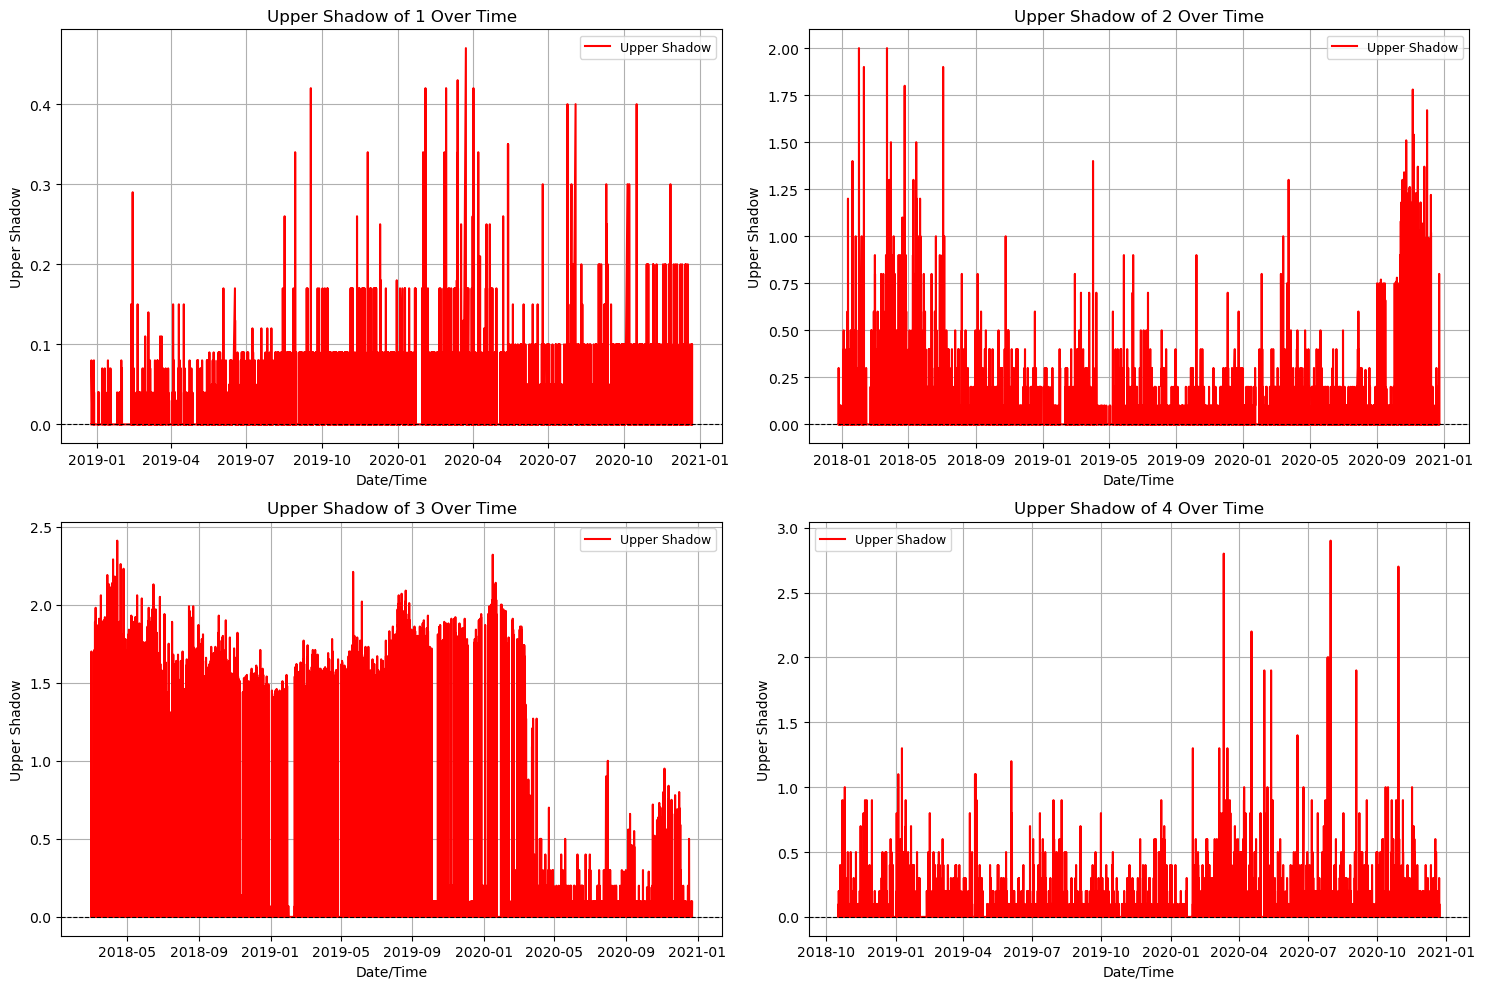

In [122]:
n_rows = math.ceil(n_tickers / n_cols)  

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes1 = axes1.flatten()

for i, ticker in enumerate(tickers):
    ticker_data = df[df['Ticker'] == ticker]
    
    ax = axes1[i]
    ax.plot(ticker_data['Date/Time'], ticker_data['Upper_Shadow'], label='Upper Shadow', color='red')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f"Upper Shadow of {ticker} Over Time", fontsize=12)
    ax.set_xlabel("Date/Time", fontsize=10)
    ax.set_ylabel("Upper Shadow", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes1)):
    fig1.delaxes(axes1[i])

plt.tight_layout()
plt.show()

1. **1**: Small and stable upper shadow, with little intra-session volatility → Suitable for long-term investment.  
2. **2**: Long and highly fluctuating upper shadow → Sensitive to news, suitable for short-term trading.  
3. **3**: Moderately fluctuating upper shadow, often long during gold price volatility periods → Stable but occasionally sensitive.  
4. **4**: Stable upper shadow, occasionally long due to real estate news → Suitable for medium-term investment.  

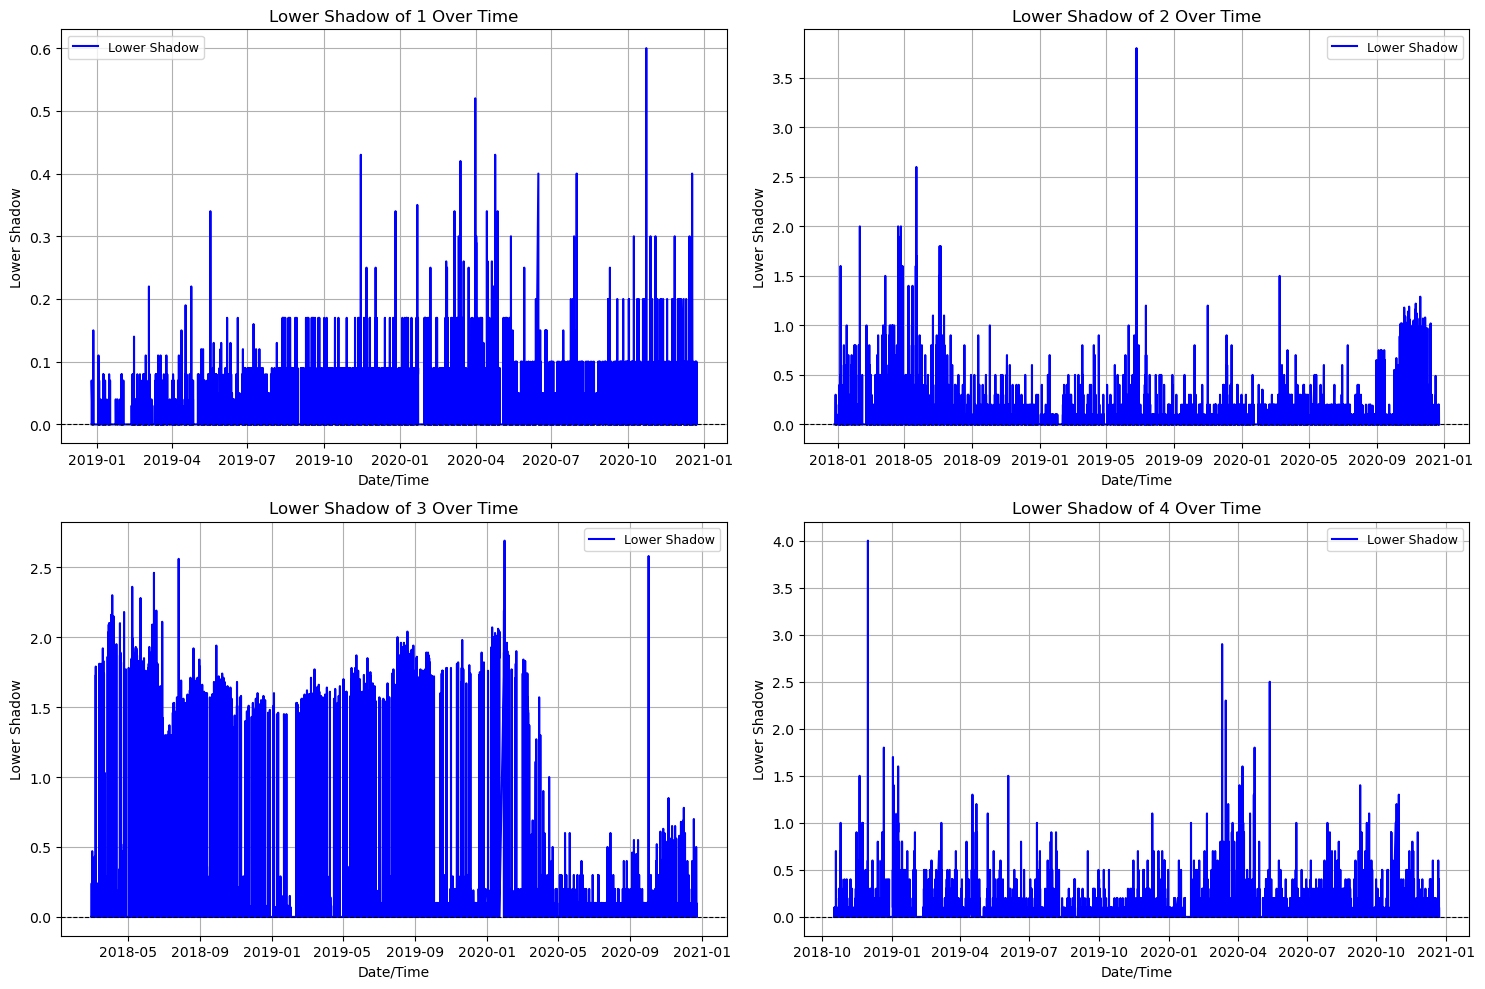

In [123]:
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes2 = axes2.flatten()

for i, ticker in enumerate(tickers):
    ticker_data = df[df['Ticker'] == ticker]
    
    ax = axes2[i]
    ax.plot(ticker_data['Date/Time'], ticker_data['Lower_Shadow'], label='Lower Shadow', color='blue')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f"Lower Shadow of {ticker} Over Time", fontsize=12)
    ax.set_xlabel("Date/Time", fontsize=10)
    ax.set_ylabel("Lower Shadow", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid()

for i in range(len(tickers), len(axes2)):
    fig2.delaxes(axes2[i])

plt.tight_layout()
plt.show()


1. **1**:  
   - **Small and stable lower shadow**, below 0.2.  
   - Indicates prices are rarely pushed significantly lower → **Stable**, suitable for long-term investment.  

2. **2**:  
   - **Highly volatile**, sometimes exceeding 1.5.  
   - Reflects strong buying pressure at lower prices → **High volatility**, suitable for short-term trading.  

3. **3**:  
   - **Moderate**, usually ranging from 1.0 to 2.0.  
   - Reflects strong buying when prices drop, influenced by gold prices → **Balanced**, suitable for medium- and long-term investment.  

4. **4**:  
   - **Moderately stable**, mostly below 1.0, with occasional spikes.  
   - Prices are influenced by the real estate market → **Moderately stable**, suitable for medium-term investment.  

**Summary**:  
- **1**: The most stable, with minimal fluctuations.  
- **2**: Highly volatile, risky but offers many opportunities.  
- **3**: Balanced between stability and opportunity.  
- **4**: Moderately stable, dependent on the market.  

# Calcula RSI, ATR, BB_upper, BB_middle, BB_lower, Future_Close, Price_Change, Direction

**1. RSI (Relative Strength Index)**:  
   ```python
   df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
   ```  
   - **Meaning**: RSI measures price strength over a period (typically 14 days) to assess whether a stock is in an overbought or oversold zone. It identifies buy/sell signals based on market conditions.  
   - **General rules**:  
     - RSI > 70: Overbought (price may decrease).  
     - RSI < 30: Oversold (price may increase).  

**2. ATR (Average True Range)**:  
   ```python
   df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
   ```  
   - **Meaning**: ATR measures the price volatility of a stock over a period (14 days). It evaluates the stock's risk level.  
   - **General rules**:  
     - High ATR: High volatility, high risk.  
     - Low ATR: Low volatility, stable market.  

**3. Bollinger Bands (BBands)**:  
   ```python
   df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20)
   ```  
   - **Meaning**: Bollinger Bands create three bands to evaluate price volatility:  
     - **BB_upper**: Upper band (price exceeds normal levels).  
     - **BB_middle**: Middle line (simple moving average).  
     - **BB_lower**: Lower band (price drops below normal levels).  
   - **General rules**:  
     - When price touches or exceeds BB_upper: Possible downward adjustment.  
     - When price touches or falls below BB_lower: Possible upward recovery.  

In [124]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20)


**1. `Future_Close`**: Retrieves the closing price of a session **N days in the future**. This helps determine the price level after a certain period to evaluate whether the price trend increases or decreases.  
   ```python
   df['Future_Close'] = df['Close'].shift(-N)
   ```  

**2. `Price_Change`**: Calculates the price difference between the current closing price and the closing price after N days.  
   - **Positive value**: Price increases after N days.  
   - **Negative value**: Price decreases after N days.  
   - Used to determine future price increases or decreases to evaluate price performance.  
   ```python
   df['Price_Change'] = df['Future_Close'] - df['Close']
   ```  

**3. `Direction`**: Measures future price increase/decrease to assess the current investment strategy.  
   ```python
   df['Direction'] = (df['Price_Change'] > 0).astype(int)
   ```  
   - **1**: Price is predicted to increase (`Price_Change` > 0).  
   - **0**: Price is predicted to decrease or remain unchanged (`Price_Change` ≤ 0).  

In [125]:
N = 5  
df['Future_Close'] = df['Close'].shift(-N)
df['Price_Change'] = df['Future_Close'] - df['Close']
df['Direction'] = (df['Price_Change'] > 0).astype(int)

In [126]:
df['Direction'].value_counts()

Direction
0    300528
1    158807
Name: count, dtype: int64

In [127]:
df.head(5)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Delta_Price,Grap,...,Upper_Shadow,Lower_Shadow,RSI,ATR,BB_upper,BB_middle,BB_lower,Future_Close,Price_Change,Direction
0,1,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0,NaN,NaN,...,0.00,0.0,NaN,NaN,NaN,NaN,NaN,30.74,-0.15,0
1,1,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0,NaN,-0.08,...,0.00,0.0,NaN,NaN,NaN,NaN,NaN,30.66,-0.15,0
2,1,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0,NaN,-0.07,...,0.07,0.0,NaN,NaN,NaN,NaN,NaN,31.11,0.37,1
3,1,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0,-0.15,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,NaN,31.19,0.45,1
4,1,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0,-0.07,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,NaN,31.19,0.45,1


In [128]:
df.dropna(inplace=True)

In [129]:
df.isna().sum().sum()

0

In [130]:
df.shape

(459302, 21)